#### AI Travel Agent & Expense Planner
##### Purpose: Trip planning for any city worldwide with Realtime data.

In [1]:
from langgraph.graph import START,END,StateGraph,MessagesState
from langchain_community.tools import tool
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph.message import MessagesState
from typing import TypedDict, List, Union
from langchain_core.messages import BaseMessage
from typing import Annotated,TypedDict,List,Sequence
from pydantic import BaseModel,Field
from langchain_core.messages import BaseMessage
import operator
from langchain_community.utilities.alpha_vantage import AlphaVantageAPIWrapper


class MessageState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], operator.add]
    step:int
    origin: str
    destination: str
    days: float
    budget: float

In [2]:
from pydantic import BaseModel,Field
from typing import List

class Format(BaseModel):
    attractions:List[str]=Field(description="list of top 5 attractions at given location")
    restaurants:List[str]=Field(description="list of top 5 restaurants at given location")
    activities:List[str]=Field(description="list of top 5 activities to do, at given location")
    transportation:List[str]=Field(description="list of ways to transport from place of origin to given location")
    


In [3]:
from langchain_core.output_parsers import PydanticOutputParser
from langchain_groq import ChatGroq

output_parser=PydanticOutputParser(pydantic_object=Format)
llm=ChatGroq(model="llama-3.1-8b-instant")

from langchain_core.prompts import PromptTemplate


In [4]:
@tool
def get_attarction_activites(Location:str,origin:str)->str:

    """This tool provides list of top 5 attractions, list of top 5 resturants with multi-cusines, list of top 5 activities to do and ways of transporation in given location 
    
    Args:
        Location (str): Trip Destination location
        origin (str): Place of origin for trip
        

    Returns:
        str: Deatils of attrcation of given location
        
        """
    
    
    prompt=PromptTemplate.from_template("""You are a helpful assistant that provides the following details about a destination:
                                            - Top 5 tourist attractions
                                            - Top 5 multi-cuisine restaurants
                                            - Top 5 activities to do
                                            - Ways of transportation from the place of origin to the destination

                                            Place of origin: {origin}
                                            Destination: {Location}

                                            Respond ONLY in the following JSON format:
                                            {format_instructions}
                                            """)
    
    chain= prompt| llm | output_parser
    res= chain.invoke({"Location":Location,"origin":origin,"format_instructions":output_parser.get_format_instructions()})
    print("res",res)

    
    
    return res

In [5]:
#get_attarction_activites.invoke({"Location":"london","origin":"india"})




#### Using `PyOWM` to fetch weather information of given Location

In [6]:
import os
import pyowm
from dotenv import load_dotenv

from warnings import filterwarnings
filterwarnings("ignore")

load_dotenv()

c:\Users\divya\Documents\GitHub\Agentic\myvenv\Lib\site-packages\pyowm\commons\cityidregistry.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


True

In [7]:
@tool
def get_weather_detail(Location:str)->str:
    
    """This tool provides current and forecasting weather for given location"""

    owm = pyowm.OWM(os.getenv("openweatherkey_one"))
    weather_mgr = owm.weather_manager()


    # Current weather
    observation = weather_mgr.weather_at_place(Location)
    weather_now = observation.weather
    current = {
        "temperature_celsius": weather_now.temperature("celsius")["temp"],
        "humidity": weather_now.humidity,
        "wind_speed_mps": weather_now.wind()["speed"],
        "status": weather_now.detailed_status
    }

    # Forecast (next 5 x 3h intervals)
    forecast = weather_mgr.forecast_at_place(Location, '3h')
    forecast_data = []
    for weather in forecast.forecast.weathers[:5]:  # limit to first 5 intervals
        entry = {
            "time": str(weather.reference_time('iso')),
            "temperature_celsius": weather.temperature("celsius")["temp"],
            "humidity": weather.humidity,
            "wind_speed_mps": weather.wind()["speed"],
            "status": weather.detailed_status
        }
        forecast_data.append(entry)

    result = {
        "location": Location,
        "current_weather": current,
        "forecast_next_15h": forecast_data
    }
    

    
    return str(result)
        
    

In [8]:
#get_weather_detail.invoke({"Location":"London"})

In [9]:

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain_community.tools import tool
search_llm=ChatGroq(model="llama-3.1-8b-instant")

Tavily_search=TavilySearchResults()

In [10]:
@tool
def search_hotels(Location:str,budget:float,days:float)->str:
    """This tool searches for hotels and its prices in given location"""


    search_llm=ChatGroq(model="llama-3.1-8b-instant")
    price_day=budget/(days+2)
    search_llm=ChatGroq(model="llama-3.1-8b-instant")
    hotels=search_llm.invoke(f"No description required, Just give list of Hotel names in given {Location} with price per day {price_day}")
    print(hotels.content)
    Hotel_name=input("Enter a Hotel name that you would like to check cost estimation")
    
    return Hotel_name


    
    


In [11]:
@tool
def get_hotel_price(Hotel_name:str,Location:str,budget:float,days:float)->str:
        """This tool provides price per Night for a given Hotel"""
        
        res=Tavily_search.invoke(f"Provide price per night of {Hotel_name} in {Location}")
        print(res)
        
         # Convert list of dicts to plain text (context)
        context_text = "\n\n".join(
                f"Title: {r['title']}\nURL: {r['url']}\nContent: {r['content']}" for r in res 
        )

        budget_hotel = budget / (days + 2)

        print(context_text)

        
        prompt = f"""
        You are provided with hotel search results.

        Context:
        {context_text}

        Take lowest per-night price of the hotel based on the above content.
        Compare it with the allowed per-night budget: ${budget_hotel:.2f}.

        Then calculate total cost for {days} nights.
        Also calculate how much budget will remain after booking from total budget: ${budget:.2f}

        Return the answer in 2-3 lines, human-readable format.
        """

        result = search_llm.invoke(prompt)

        return result


In [12]:
@tool
def calculate_total_cost(price:float,days:float)->float:
        """This tool provides total cost for given hotel price and no.of days"""
        pass

In [13]:
@tool
def add(a:float,b:float)->float:
    """This tool provides addition of two numbers"""
    pass

In [14]:
@tool
def multiply(a:float,b:float)->float:
    """This tool provides multiplication of two numbers"""
    pass

In [15]:
@tool
def currency_conversion()->float:
    """This tool converts given USD to equivalent currency amount in given location"""
    pass

In [16]:
def complete_Itenary_generation():
    pass


In [17]:
def total_trip_expenses():
    pass

In [18]:
def travel_Planning(state:MessageState):
    origin=input("Enter the place of origin for the journey").lower()
    location=input("Enter the city name for which you want travel plan and details").lower()
    Days=input("Enter no.of days for the trip")
    Days=float(Days)
    budget=input("Enter max budget in origin country currecy, for entire trip")
    budget=float(budget)
    print("Please wait...., while our AI travel agent is planning Iternary according to your details.....")
    # print(type(Days),type(budget))
    state["origin"] = origin
    state["destination"] = location
    state["days"] = Days
    state["budget"] = budget


    SYSTEM_PROMPT = SystemMessage(
    content=f"""You are a helpful assistant tasked with currency conversion from Origin: {origin} to Destination: {location}, just provide currency codes nothing else
    Return each code on a separate line like this:\n\nINR\nGBP """)
    res=search_llm.invoke([SYSTEM_PROMPT]+ ["Return only the currency codes (e.g., INR, GBP), each on a separate line, of Origin and Destination"])
    origin_currency, destination_currency = res.content.split('\n')
    os.environ["ALPHAVANTAGE_API_KEY"] = os.getenv("ALPHAVANTAGE_API_KEY")
    alpha_vantage = AlphaVantageAPIWrapper()
    er=alpha_vantage._get_exchange_rate(origin_currency, destination_currency)['Realtime Currency Exchange Rate']['5. Exchange Rate']
    er=float(er)
    state["budget"]=float(budget * er)
    # print("********E N D of travel_planning*********")
    state["step"]=1
    # print("state intravel_planning:", state)
    # print("step in state", state["step"])


    return state

In [19]:
myTools=[get_attarction_activites,get_weather_detail,search_hotels,get_hotel_price,calculate_total_cost,add,multiply]

In [20]:
from langchain_openai import ChatOpenAI
agent=ChatOpenAI(model="o4-mini")
React_agent=agent.bind_tools(myTools)

In [ ]:
def agent_planning(state:MessageState):
    # print("\n$$$$$$$$ start of agent planning$$$$$$$$$$$44")
    current_step=state["step"]
    


    
    # print("\n######### S T E P while entering #############\n",state["step"])

    origin = state["origin"]
    destination = state["destination"]
    days = state["days"]
    budget = state["budget"]
    step_name={
        0:"Currency conversion",
        1:"Search for Attractions and Activities",
        2:"Search for weather and forecasting",
        3:"Search for Hotels in given location",
        4:"Search price of given Hotel received from search_hotels",
        5:"END the process"
    }[current_step]

    if len(state["messages"])==0:
        context=HumanMessage(content="Start planning.")
    else:
        context=state["messages"][-1]

    template = """You are a helpful Travel planning assistant with binded tools, planning trip from {origin} to given Destination {destination}, for {days} days with total budget of {budget}.
                    Only take actions based on current step: "{current_step}".
                    Now perform step {current_step}: {step_name}.
                    Context: {context}"""

    prompt = PromptTemplate.from_template(template)

    # Assuming React_agent expects PromptTemplate and chaining works
    chain = prompt | React_agent

    inputs = {
        "origin": origin,
        "destination": destination,
        "days": days,
        "budget": budget,
        "current_step": current_step,
        "step_name": step_name,
        "context": context,
    }
    res = chain.invoke(inputs)
    

    if res.tool_calls:
        state["step"]+=1
        # print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
        # print("\nstep incremented",state["step"])
    
    # print("\n--------- S T A T E ------------")
    # for m in state["messages"]:
    #     m.pretty_print()


    return {"messages":[res],"step":state["step"]}

In [22]:
# print(res.tool_calls)


In [23]:
workflow1=StateGraph(MessageState)





In [24]:
workflow1.add_node("start_planning",travel_Planning)

In [25]:
workflow1.add_node("Agent_Planning",agent_planning)

In [26]:
myTools=[get_attarction_activites,get_weather_detail,search_hotels,get_hotel_price,calculate_total_cost,add,multiply,currency_conversion]

In [27]:
tools=ToolNode(myTools)

In [28]:
workflow1.add_node("tools",tools)

In [29]:
workflow1.add_edge(START,"start_planning")

In [30]:
workflow1.add_edge("start_planning","Agent_Planning")

In [31]:
workflow1.add_conditional_edges("Agent_Planning",tools_condition)
workflow1.add_edge("tools","Agent_Planning")

In [32]:
react_agent=workflow1.compile()

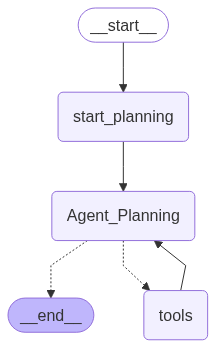

In [33]:
from IPython.display import Image, display
display(Image(react_agent.get_graph().draw_mermaid_png()))

In [34]:
from langchain_core.messages import HumanMessage, SystemMessage
#react_agent.invoke({"messages":[]})



In [35]:
for output in react_agent.stream({"messages":[]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

Please wait...., while our AI travel agent is planning Iternary according to your details.....
here is output from start_planning
_______
{'messages': [], 'origin': 'india', 'destination': 'london', 'days': 5.0, 'budget': 2580.0, 'step': 1}



****************************
2580.0
here is output from Agent_Planning
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_55OjNB0cIMQj1N8Zgyug6Awk', 'function': {'arguments': '{"Location":"london","origin":"india"}', 'name': 'get_attarction_activites'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 225, 'prompt_tokens': 385, 'total_tokens': 610, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'id': 'chatcmpl-Bjv4Sc5FCyeYySEHHPpO8VVNn8UHw'

In [36]:

Premier Inn London Tower Bridge

SyntaxError: invalid syntax (3199407414.py, line 1)